# Plotting with ACS plotting script and regional statistics
Using code from https://github.com/AusClimateService/plotting_maps/tree/main

In [1]:
cd /g/data/mn51/users/dh4185/repos_collab/plotting_maps

/g/data/mn51/users/dh4185/repos_collab/plotting_maps


In [2]:
# import ACS plotting maps and Xarray.
import sys
sys.path.append("/g/data/mn51/users/dh4185/repos_collab/plotting_maps")

# import needed packages
from acs_area_statistics import get_regions, acs_regional_stats # this line has been updated 19 August 2024
regions = get_regions(["ncra_regions", "australia"]) # this line has been updated 19 August 2024
from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict
from acs_plotting_maps import plot_acs_hazard_3pp
import xarray as xr
import numpy as np
import lib_david
import pandas as pd
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/"
index = "AI-atmospheric-based"
index_short = "AI"
data_type = "2D"
rcp = "rcp85"
mme_set = ["model","bc"]
quantiles = [0.1,0.5,0.9]

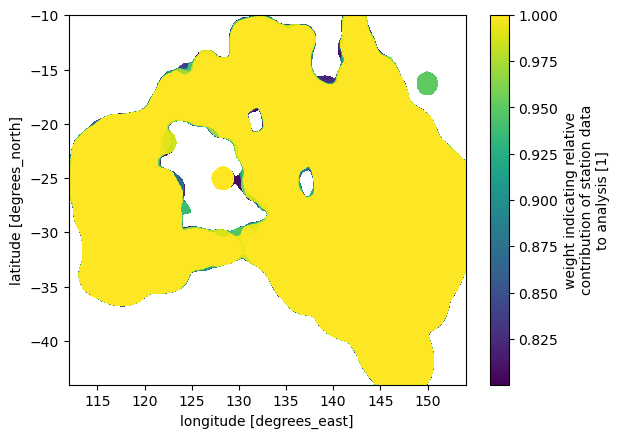

In [4]:
#< AGCD masking
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc").sel(lat=slice(-44,-10),lon=slice(112,154))
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)
mask_ds.fraction.where(q_mask.mask).plot()

In [6]:
#< If mask file doesn't exist, run below command to create it
# python3 /g/data/mn51/users/dh4185/hazards-drought/AGCD_masking.py --ClimStartYr 1975 --ClimEndYr 2005

### GWLs

GWL: GWL1.2
Percentile: 10
Percentile: 50
Percentile: 90
GWL: GWL1.5
Percentile: 10
Percentile: 50
Percentile: 90
GWL: GWL2.0
Percentile: 10
Percentile: 50
Percentile: 90
GWL: GWL3.0
Percentile: 10
Percentile: 50
Percentile: 90


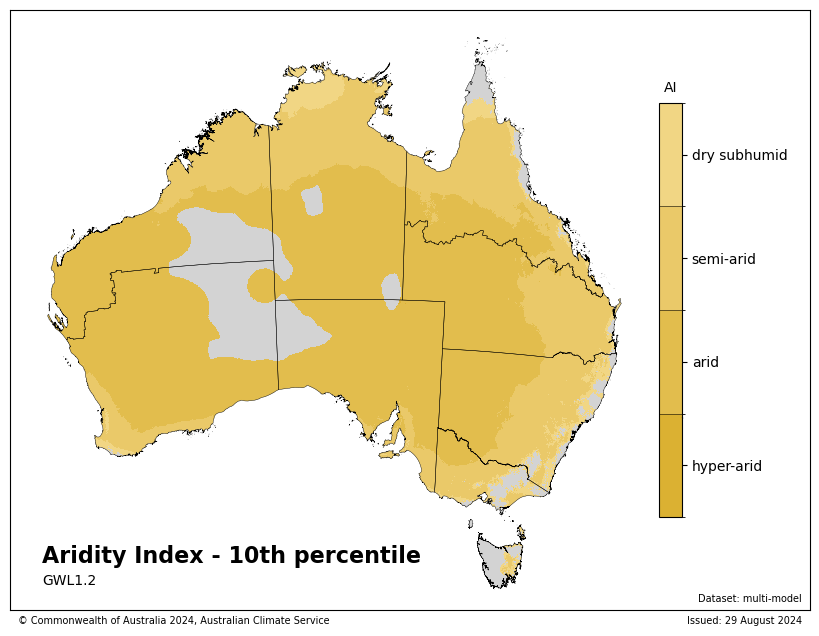

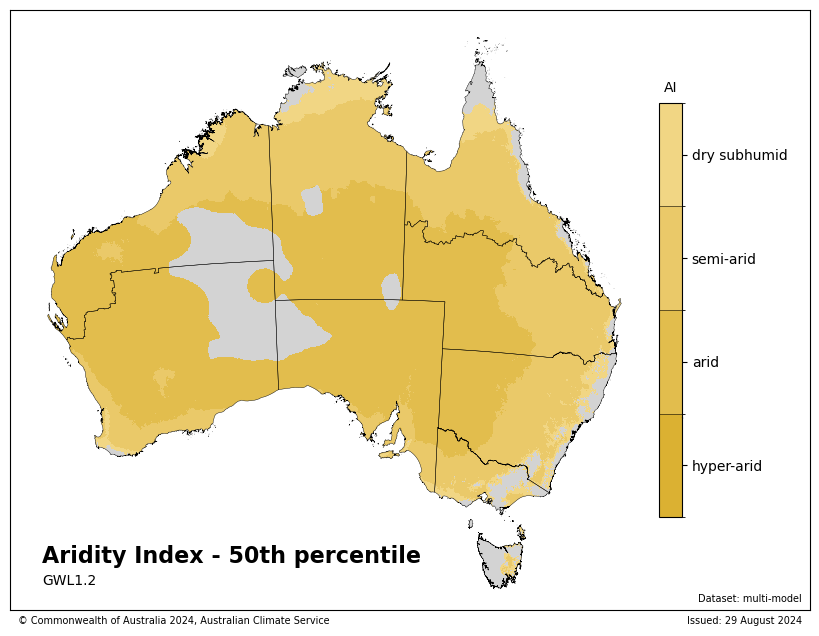

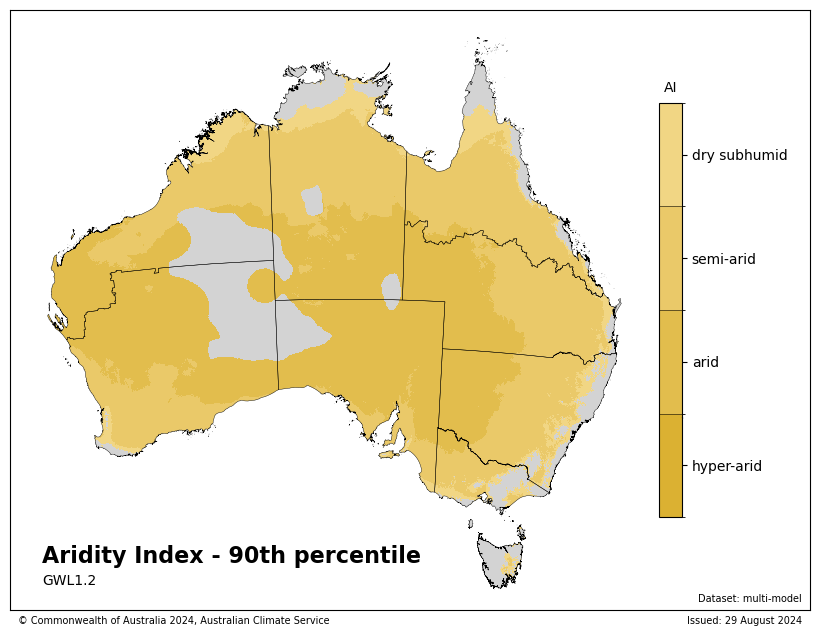

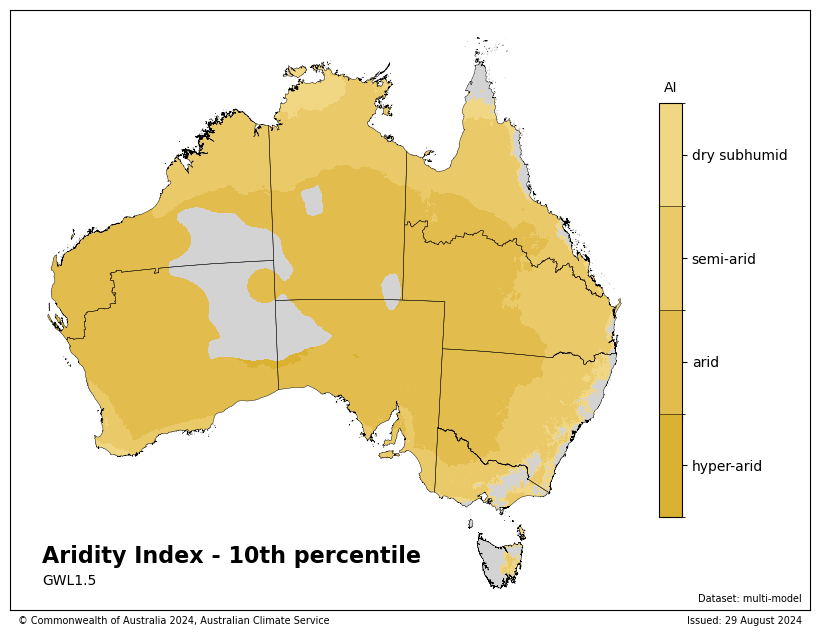

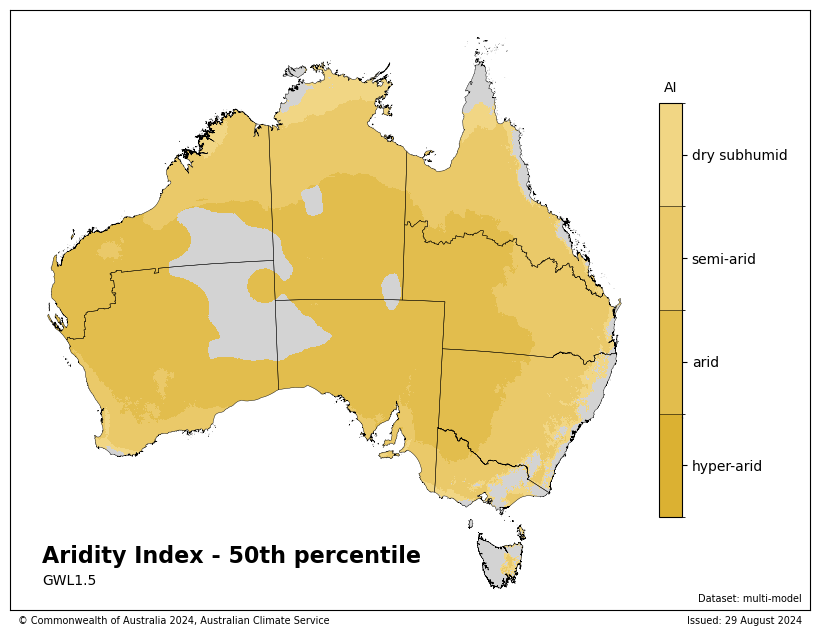

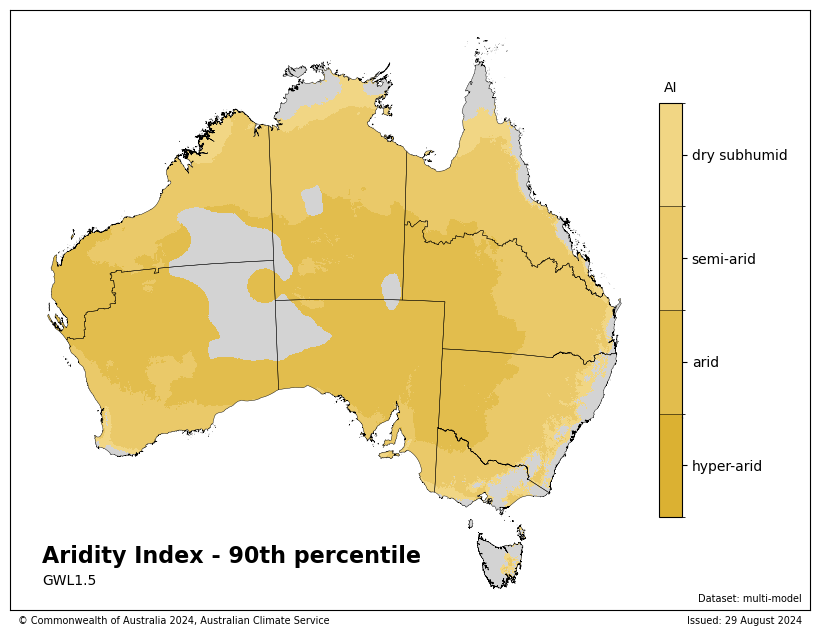

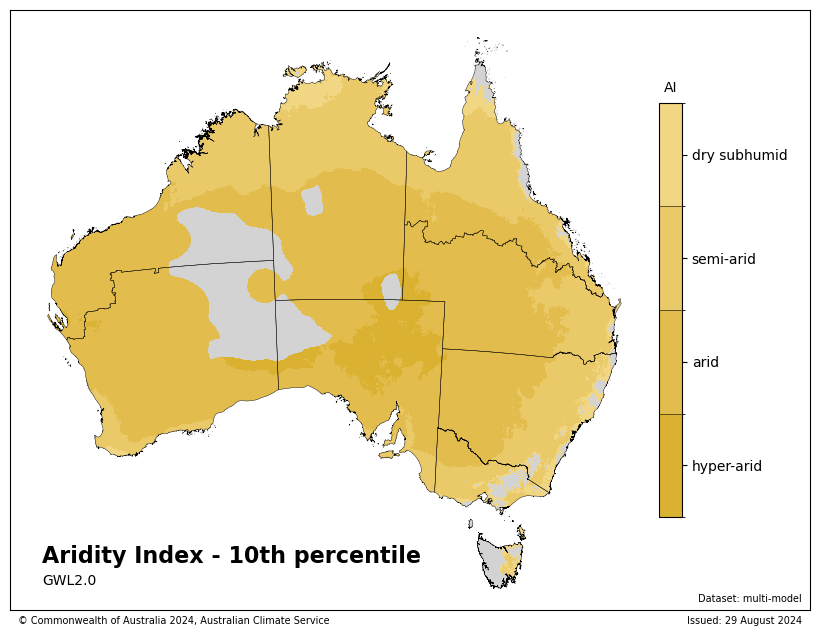

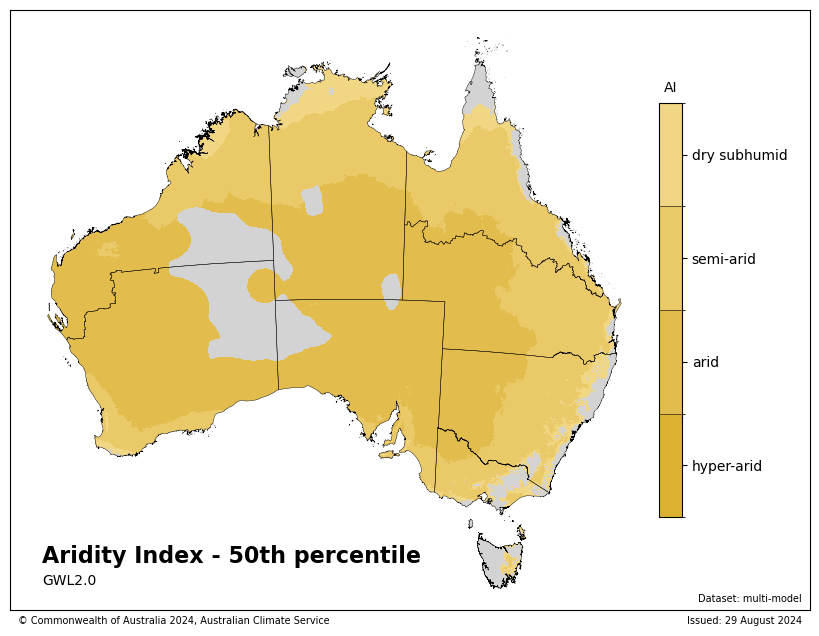

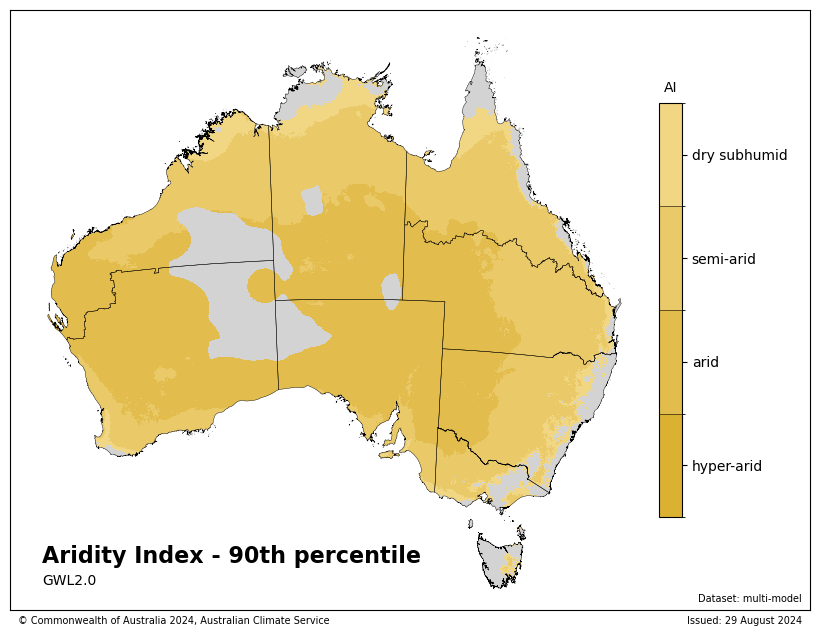

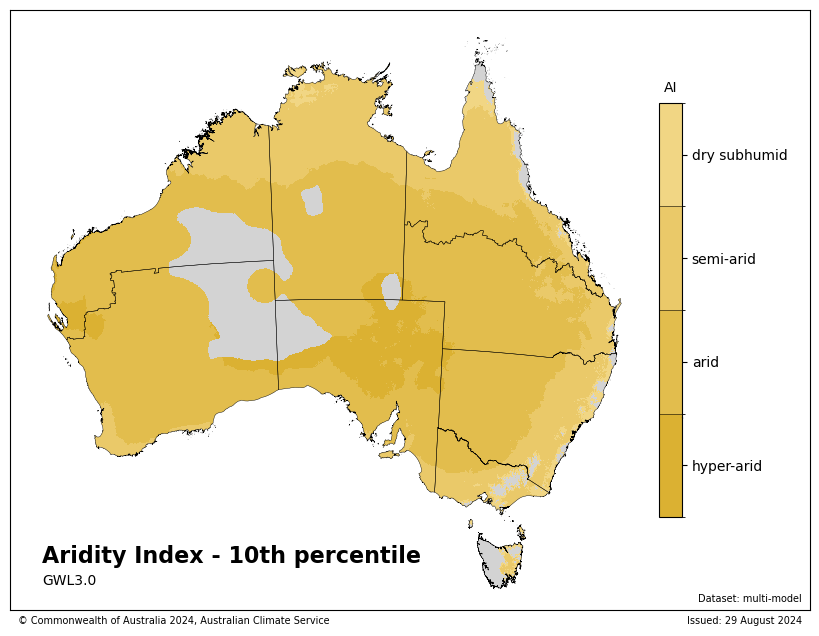

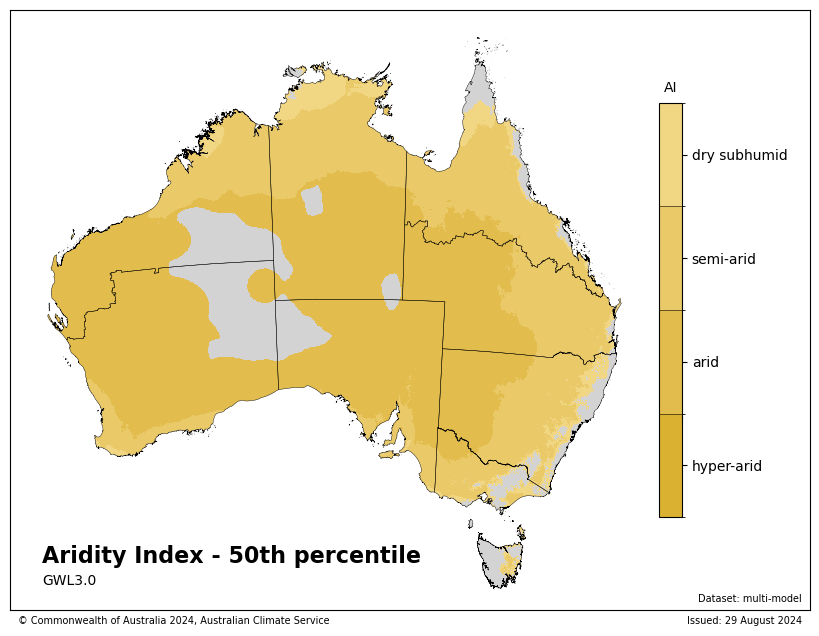

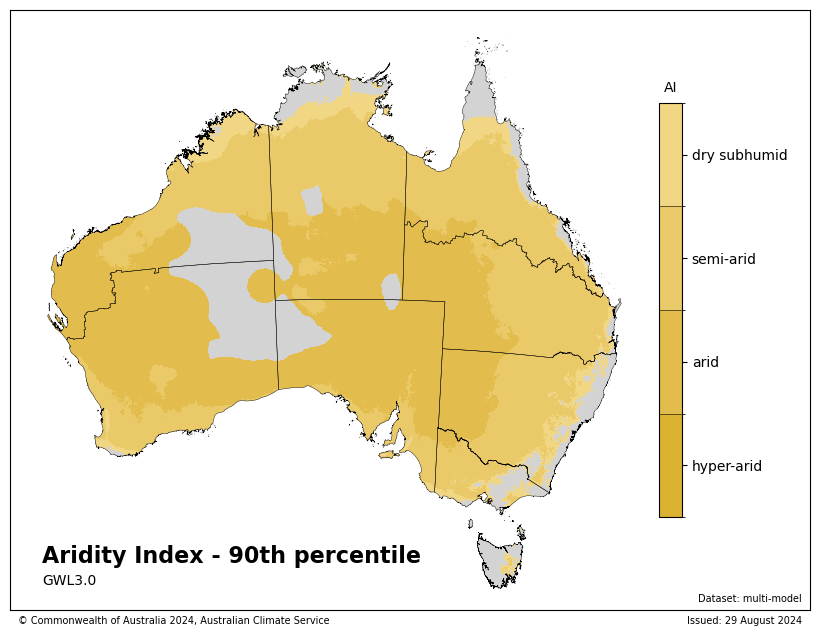

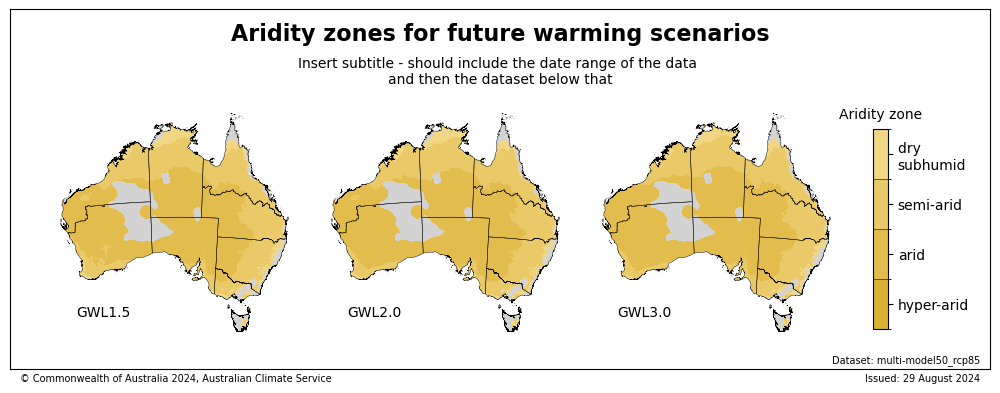

In [6]:
# GWLs

gwl = ["GWL12","GWL15","GWL20","GWL30"]
all_prcntl_da = []

for _gwl in gwl:
    ds = xr.open_dataset(f"{root_dir}{index}_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{_gwl}.nc")
    print(f"GWL: {_gwl[:4]}.{_gwl[4:]}")
    
    for q in quantiles:
        prcntl = int(q*100)
        print(f"Percentile: {prcntl}")
        quantiles_da = ds.quantile(q, dim = "model").AI.where(q_mask.mask)

        if prcntl == 50:
            all_prcntl_da.append(quantiles_da)
        
        plot_acs_hazard(data =  quantiles_da.where(quantiles_da<0.65),
                regions = regions_dict['ncra_regions'],
                title = f"Aridity Index - {prcntl}th percentile ",
                date_range = _gwl[:4]+"."+_gwl[4:],
                cmap = cmap_dict["aridity"],
                ticks = tick_dict['aridity_index_ticks'],
                tick_labels = ["hyper-arid","arid","semi-arid","dry subhumid"],#tick_dict['aridity_index_labels'],
                cbar_label = "AI",
                dataset_name = "multi-model",
                watermark = "",
                outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{_gwl}_percentile{prcntl}_plot.png",
                );

ds_all_50 = xr.merge(all_prcntl_da).squeeze()

plot_acs_hazard_3pp(ds_gwl15 = ds_all_50.sel(gwl="GWL15").AI.where(ds_all_50.sel(gwl="GWL15").AI<0.65), 
                    ds_gwl20 = ds_all_50.sel(gwl="GWL20").AI.where(ds_all_50.sel(gwl="GWL20").AI<0.65),
                    ds_gwl30 = ds_all_50.sel(gwl="GWL30").AI.where(ds_all_50.sel(gwl="GWL30").AI<0.65),
                    regions = regions_dict['ncra_regions'],
                    cbar_label=f"Aridity zone",
                    title=f"Aridity zones for future warming levels", 
                    date_range = "Insert subtitle - should include the date range of the data \nand then the dataset below that", 
                    # baseline = "GWL1.2", 
                    dataset_name= "multi-model50_rcp85",
                    issued_date=None,
                    watermark="", 
                    cmap = cmap_dict["aridity"],
                    ticks = tick_dict['aridity_index_ticks'],
                    tick_labels = ["hyper-arid","arid","semi-arid","dry \nsubhumid"],
                    outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_GWL15-30_MME50.png",
                    );


## GWL change

In [12]:
gwl = ["GWL15","GWL20","GWL30"]
all_MME50_prct_da = []
all_MME50_abs_da = []
all_MME50_zone_da = []

for _gwl in gwl:
    print(f"GWL: {_gwl[:4]}.{_gwl[4:]}")
    
    prct_change = f"{_gwl}_prct-change-to-GWL12"
    quantiles_prct_ds = xr.open_dataset(f"{root_dir}{index}_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{prct_change}.nc")

    change = f"{_gwl}_abs-change-to-GWL12"
    quantiles_ds = xr.open_dataset(f"{root_dir}{index}_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{change}.nc")

    zone_change = f"{_gwl}_zone-change-to-GWL12"
    quantiles_zones_ds = xr.open_dataset(f"{root_dir}{index}_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{zone_change}.nc")
    
    for q in quantiles:
        prcntl = int(q*100)
        print(f"Percentile: {prcntl}")
        quantiles_prct_da = quantiles_prct_ds.quantile(q, dim = "model").AI.where(q_mask.mask)
        quantiles_da = quantiles_ds.quantile(q, dim = "model").AI.where(q_mask.mask)
        quantiles_zone_da = quantiles_zones_ds.quantile(q, dim = "model").AI.where(q_mask.mask)
        

        if prcntl == 50:
            all_MME50_prct_da.append(quantiles_prct_da.expand_dims(GWL=[_gwl]))
            all_MME50_abs_da.append(quantiles_da.expand_dims(GWL=[_gwl]))
            all_MME50_zone_da.append(quantiles_zone_da.expand_dims(GWL=[_gwl]))
        
        plot_acs_hazard(data = quantiles_prct_da,#.where(quantiles_da<0.65),
                regions = regions_dict['ncra_regions'],
                title = f"Aridity Index change - {prcntl}th percentile ",
                date_range = _gwl[:4]+"."+_gwl[4:],
                cmap = cmap_dict["anom_r"],
                ticks = np.arange(-30, 35, 5),
                # tick_labels=np.arange(-30, 40, 10),
                cbar_label = "AI %-change",
                dataset_name = "multi-model",
                watermark = "",
                outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{prct_change}_percentile{prcntl}_plot.png",
                );
        
        plot_acs_hazard(data = quantiles_da,#.where(quantiles_da<0.65),
                regions = regions_dict['ncra_regions'],
                title = f"Aridity Index change - {prcntl}th percentile ",
                date_range = _gwl[:4]+"."+_gwl[4:],
                cmap = cmap_dict["anom_r"],
                ticks = [-.1, -.075, -.05, -.025, 0, .025, .05, .075, .1],
                tick_labels = [-.1, -.075, -.05, -.025, 0, .025, .05, .075, .1],
                cbar_label = "AI change",
                dataset_name = "multi-model",
                watermark = "",
                outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{change}_percentile{prcntl}_plot.png",
                );

        plot_acs_hazard(data = quantiles_zone_da,
                regions = regions_dict['ncra_regions'],
                title = f"Aridity Index category change - {prcntl}th percentile",
                date_range = _gwl[:4]+"."+_gwl[4:],
                cmap = cmap_dict["anom_r"],
                ticks = [-2, -1, 0, 1, 2],
                tick_labels=[-2, -1, 0, 1, 2],
                cbar_label = "AI class change",
                dataset_name = "multi-model",
                watermark = "",
                outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_{zone_change}_percentile{prcntl}_plot.png",
                );

ds_MME50_prct = xr.merge(all_MME50_prct_da).squeeze()
ds_MME50_abs = xr.merge(all_MME50_abs_da).squeeze()
ds_MME50_zone = xr.merge(all_MME50_zone_da).squeeze()

GWL: GWL1.5
Percentile: 10
Percentile: 50
Percentile: 90
GWL: GWL2.0
Percentile: 10
Percentile: 50
Percentile: 90
GWL: GWL3.0
Percentile: 10
Percentile: 50
Percentile: 90


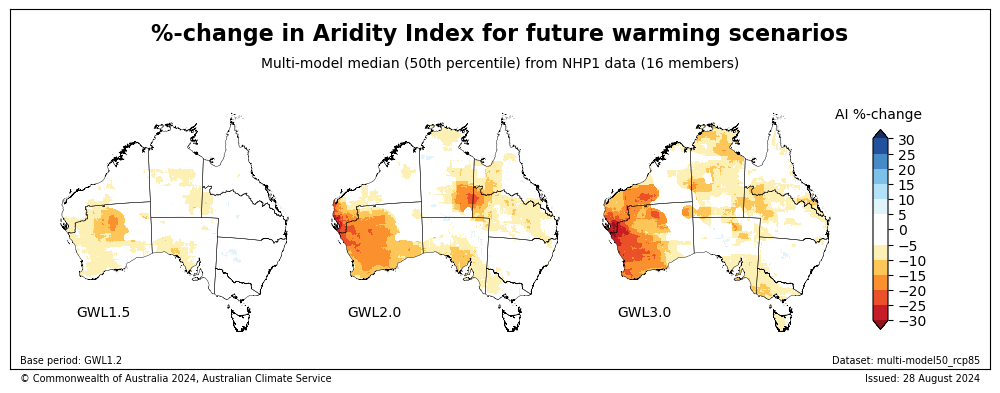

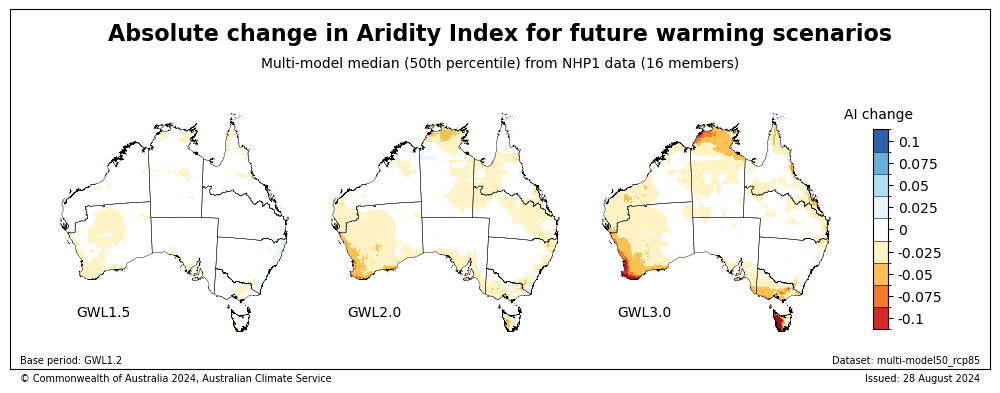

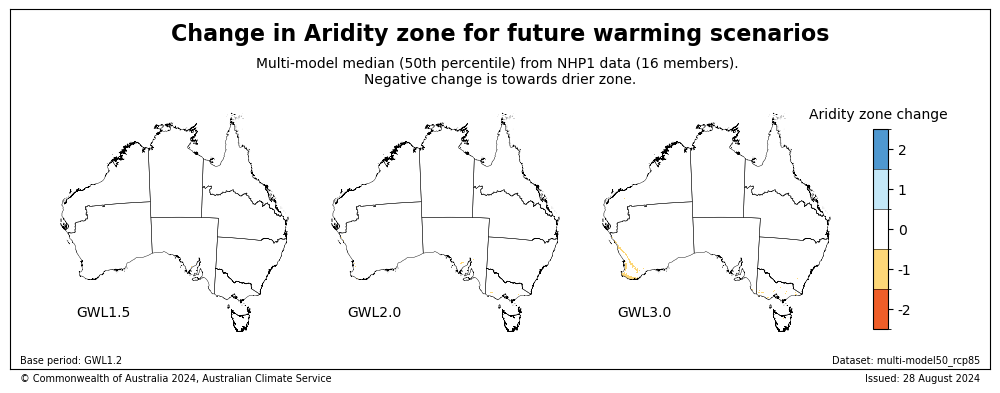

In [16]:
#< 3pp for ds_MME50_prct
plot_acs_hazard_3pp(ds_gwl15 = ds_MME50_prct.sel(GWL="GWL15").AI, 
                    ds_gwl20 = ds_MME50_prct.sel(GWL="GWL20").AI,
                    ds_gwl30 = ds_MME50_prct.sel(GWL="GWL30").AI,
                    regions = regions_dict['ncra_regions'],
                    cbar_label=f"AI %-change ",
                    title=f"%-change in Aridity Index for future warming scenarios", 
                    date_range = "Multi-model median (50th percentile) from NHP1 data (16 members)", 
                    baseline = "GWL1.2", 
                    dataset_name= "multi-model50_rcp85",
                    issued_date=None,
                    watermark="", 
                    cmap = cmap_dict["anom_r"],
                    ticks = np.arange(-30, 35, 5),
                    outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_GWL15-30_prct-change-to-GWL12_MME50.png",
                    );

#< 3pp for ds_MME50_prct
plot_acs_hazard_3pp(ds_gwl15 = ds_MME50_abs.sel(GWL="GWL15").AI, 
                    ds_gwl20 = ds_MME50_abs.sel(GWL="GWL20").AI,
                    ds_gwl30 = ds_MME50_abs.sel(GWL="GWL30").AI,
                    regions = regions_dict['ncra_regions'],
                    cbar_label=f"AI change ",
                    title=f"Absolute change in Aridity Index for future warming scenarios", 
                    date_range = "Multi-model median (50th percentile) from NHP1 data (16 members)", 
                    baseline = "GWL1.2", 
                    dataset_name= "multi-model50_rcp85",
                    issued_date=None,
                    watermark="", 
                    cmap = cmap_dict["anom_r"],
                    ticks = [-.1, -.075, -.05, -.025, 0, .025, .05, .075, .1],
                    tick_labels = [-.1, -.075, -.05, -.025, 0, .025, .05, .075, .1],
                    outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_GWL15-30_abs-change-to-GWL12_MME50.png",
                    );

#< 3pp for ds_MME50_prct
plot_acs_hazard_3pp(ds_gwl15 = ds_MME50_zone.sel(GWL="GWL15").AI, 
                    ds_gwl20 = ds_MME50_zone.sel(GWL="GWL20").AI,
                    ds_gwl30 = ds_MME50_zone.sel(GWL="GWL30").AI,
                    regions = regions_dict['ncra_regions'],
                    cbar_label=f"Aridity zone change ",
                    title=f"Change in Aridity zone for future warming scenarios", 
                    date_range = "Multi-model median (50th percentile) from NHP1 data (16 members). \nNegative change is towards drier zone.", 
                    baseline = "GWL1.2", 
                    dataset_name= "multi-model50_rcp85",
                    issued_date=None,
                    watermark="", 
                    cmap = cmap_dict["anom_r"],
                    ticks = [-2, -1, 0, 1, 2],
                    tick_labels=[-2, -1, 0, 1, 2],
                    outfile = f"{root_dir}figures/AI-atmospheric-based_NHP1-AUS-5_{rcp}_bias-adjusted_{data_type}_GWL15-30_zone-change-to-GWL12_MME50.png",
                    );

## Heatmaps

In [7]:
files = sorted(lib_david.get_file_paths(root_dir,".nc",include=[index,rcp,data_type],exclude=["percentiles","change","GWL40","AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_2D_GWL12.nc"]))
files_GWL12 = [file for file in files if 'GWL12' in file]

len(files_GWL12)


16

### Relative change

In [10]:
def plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    min_max_extent = {1.5:10, 2.0:15, 3.0:20}
    sns.set(font_scale=1.5)
    plt.figure(figsize=(18, 7))
    colors = sns.color_palette("BrBG", 12)
    cmap = ListedColormap(colors)
    
    ax = sns.heatmap(plot_df, annot=True, cmap=cmap, linewidth=2, fmt='.0f',
                     cbar_kws={'extend':'neither', 'label':'Percent Change (%)'},
                     center=0,
                     vmin=-(min_max_extent[GWL_level]) if variable_colourbar_switch else -40,
                     vmax=(min_max_extent[GWL_level]) if variable_colourbar_switch else 40,
                     yticklabels=list(change_df['abbrevs']),
                     xticklabels=[key[:-5].replace('_', ' ').replace("r240x120-","").replace("CSIRO-CCAM-r3355-","CCAM") for key in plot_df.columns])
    
    ax.text(len(plot_df.columns) + 0.85, - 0.5, 'Median' , ha='center', va='center')
    ax.text(len(plot_df.columns) + 0.23, 12, r"$\bf{Bold}$" + ' = at least\n66% of ensemble\nmembers agree on \nsign of the change' , size=16, ha='left', va='center', bbox=dict(boxstyle="round,pad=0.7", edgecolor="black", facecolor="none", linewidth=0.25))
    for i, row in plot_df.iterrows():
        median = row.median()
        sign_agreement = ((row>0).sum()/len(row)) if median > 0 else ((row<0).sum()/len(row))
        fontweight = 'bold' if sign_agreement >= 0.66 else 'normal'
        ax.text(len(plot_df.columns) + 0.85, i + 0.5, f'{median:.1f}', ha='center', va='center', fontweight=fontweight)
        
    #make sure zero values are not coloured positively (doesn't account for -0 for whatever reason)
    
    for text in ax.texts:
        x, y = text.get_position()
        if (text.get_text()=='0' or text.get_text()=='-0') and x<16:
            ax.text(x, y, f' {text.get_text()} ', ha='center', va='center', bbox=dict(pad=10.0, edgecolor="none", facecolor="lightgrey"))
    cbar = ax.collections[0].colorbar
    cbar.ax.set_position([0.83, 0.15, 0.02, 0.7])
    
    ax.set_title(f'% - change Aridity Index for GWL {str(GWL_level/10)} relative to GWL 1.2', fontweight='bold', pad=20)
    
    plt.savefig(f'/g/data/mn51/users/dh4185/ai_figures/AI_regional_heatmap_change_GWL{GWL_level}.png', bbox_inches='tight')
    plt.show()
    plt.clf()
    return

15
---> Plotting GWL1.5 with consistent colourbar across GWLs


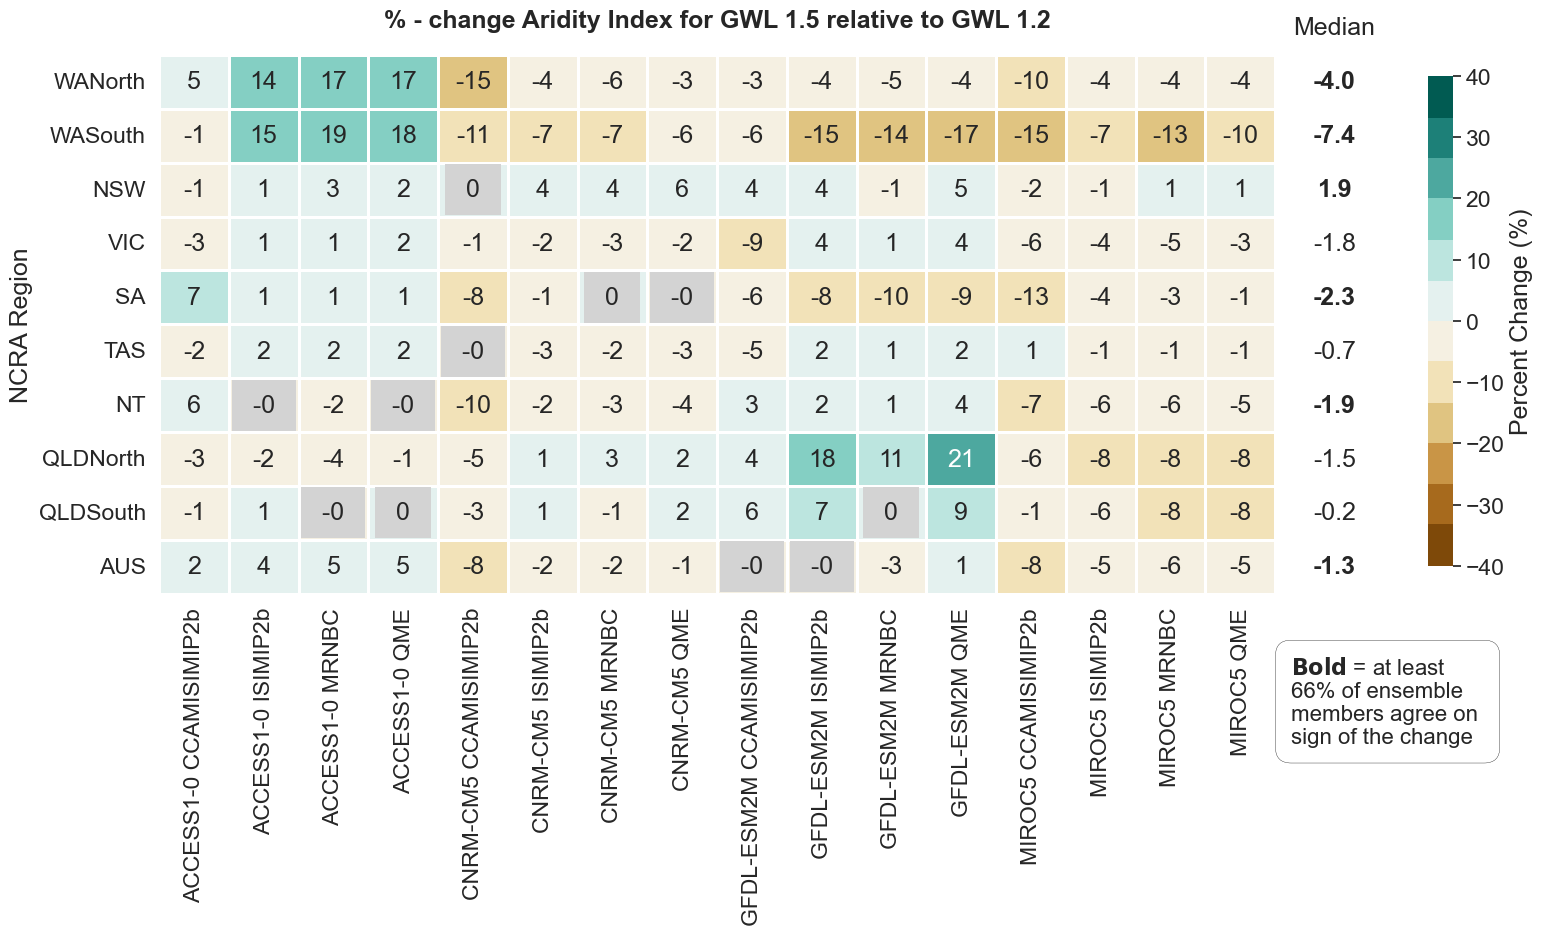

20
---> Plotting GWL2.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

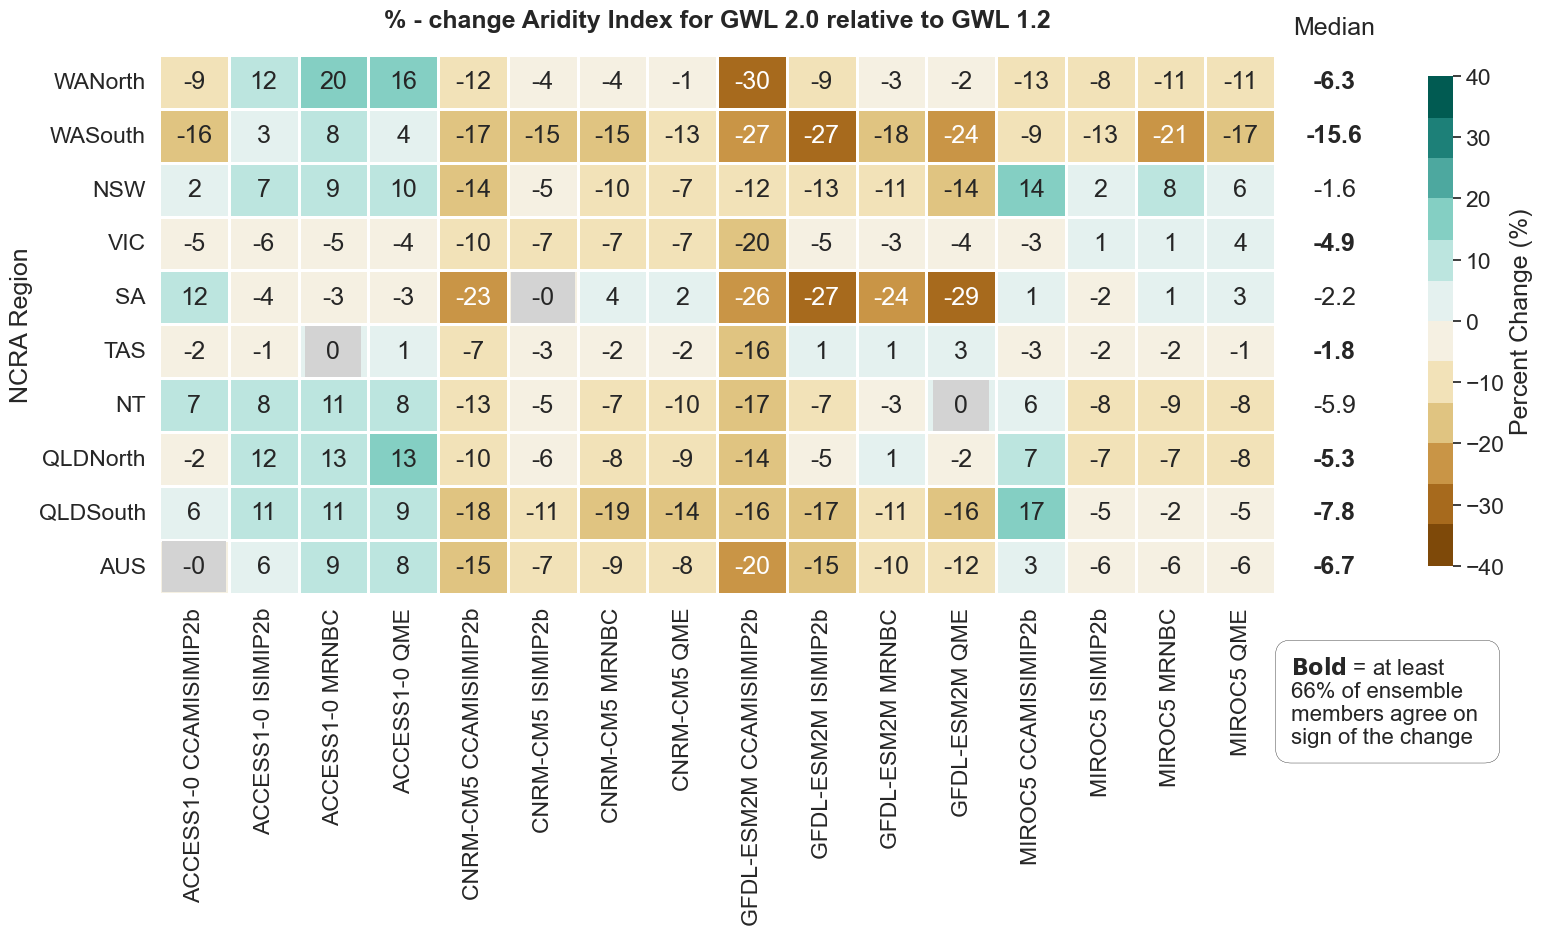

30
---> Plotting GWL3.0 with consistent colourbar across GWLs


<Figure size 640x480 with 0 Axes>

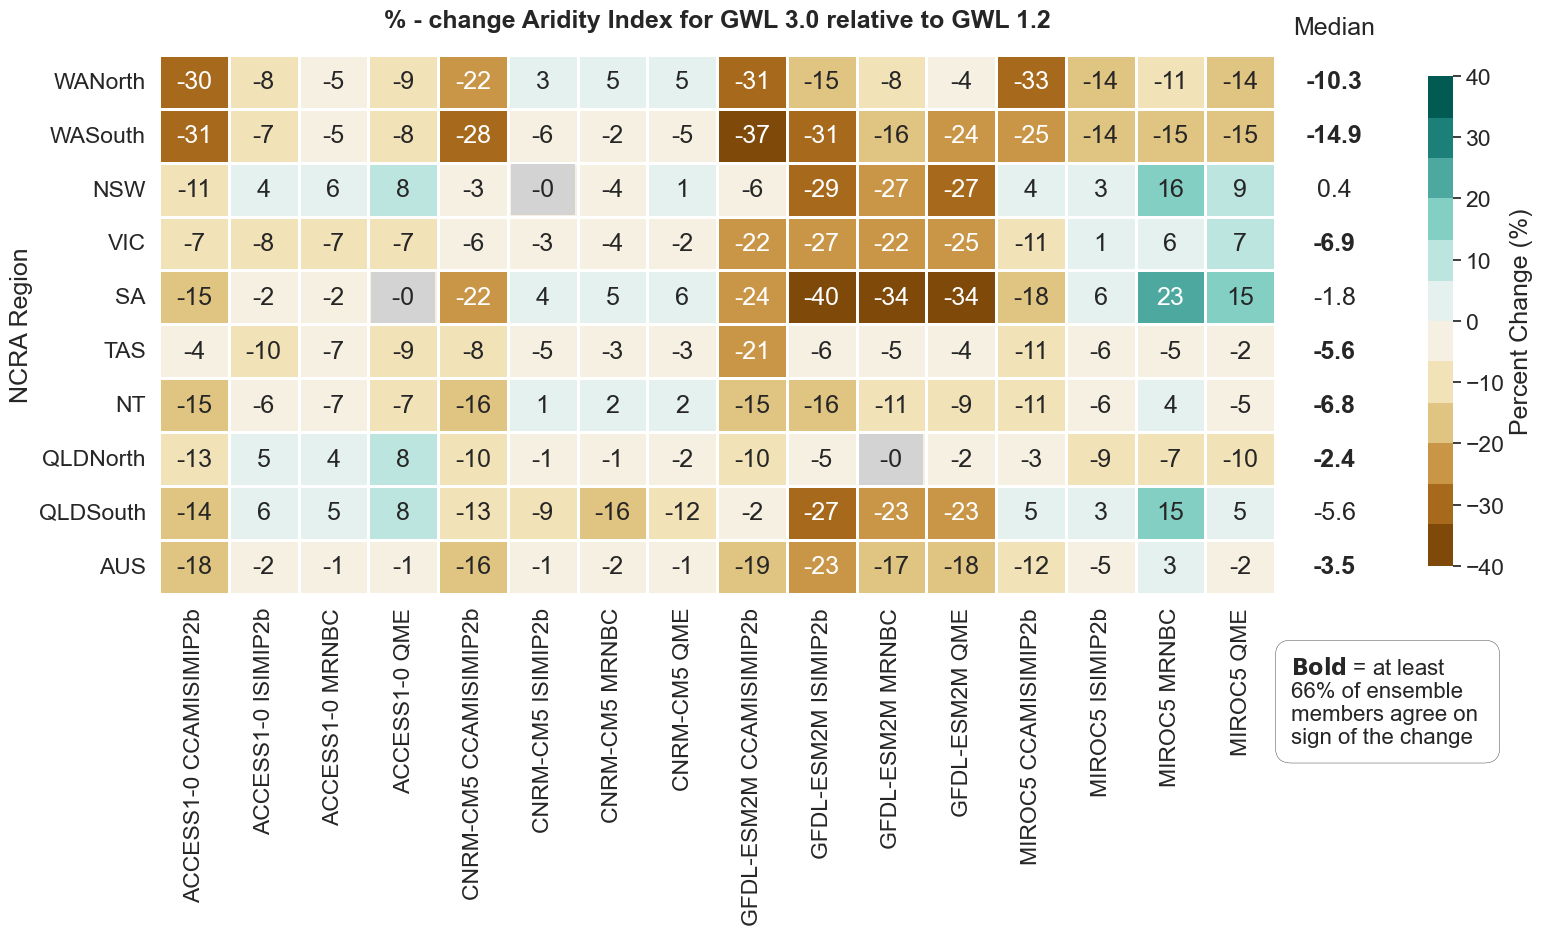

CPU times: user 14min 38s, sys: 1min 14s, total: 15min 53s
Wall time: 15min 59s


<Figure size 640x480 with 0 Axes>

In [11]:
%%time
min_max_extent = {1.5:10, 2.0:15, 3.0:20}
gwl = ["GWL12","GWL15","GWL20","GWL30"]


for GWL_level in [15,20,30]:
    print(GWL_level)
    df_list = []
    for file_GWL12 in files_GWL12:
        # print(f"GWL12 file: {file_GWL12}")
        file_GWLx = [file for file in files if file_GWL12.split('_')[3] in file and (("-").join(file_GWL12.split('-')[-4:]))[:-12] in file and f'GWL{str(GWL_level)}' in file][0]
        # print(f"GWL{GWL_level} file: {file_GWLx}")
        
        ensemble_member_name = file_GWL12.split('_')[3]+" "+file_GWL12.replace("__","_").split('_')[-3] if "CCAM" in file_GWL12 == False else file_GWL12.split('_')[3]+" "+("-").join(file_GWL12.replace("__","_").split("_")[-3].split("-")[0:5])
        
        ds_GWLx = xr.open_dataset(file_GWLx).where(q_mask.mask)
        ds_GWL12 = xr.open_dataset(file_GWL12).where(q_mask.mask)
        GWLx_change = ((ds_GWLx - ds_GWL12)/ds_GWL12*100).rename({'AI': ensemble_member_name}).round(0)      
        mask_frac = regions.mask_3D_frac_approx(GWLx_change)
        dims = ("lat", "lon",)
        change_df = acs_regional_stats(ds=GWLx_change,var=ensemble_member_name, mask=mask_frac, dims = dims, how = ["mean"]).to_dataframe()
        df_list.append(change_df[change_df.columns[-1]])

    plot_df = pd.concat(df_list, axis=1).rename_axis('NCRA Region')
    
    # print(f'---> Plotting GWL{str(GWL_level)} with variable colourbar across GWLs')
    # plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=True)
    
    print(f'---> Plotting GWL{str(GWL_level/10)} with consistent colourbar across GWLs')
    plot_heatmap(plot_df, GWL_level, variable_colourbar_switch=False)
    